In [32]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [33]:
import numpy as np
import pandas as pd
import datetime as dt



# Reflect Tables into SQLAlchemy ORM

In [42]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import text
from dateutil.relativedelta import relativedelta

In [43]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [44]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with = engine)

In [45]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [46]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`

measurement = Base.classes.measurement
station = Base.classes.station

In [47]:
# Create a session

session = Session(engine)

# Exploratory Precipitation Analysis

In [48]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(text("date DESC")).first()

('2017-08-23',)

In [51]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
most_recent = session.query(measurement.date).order_by(text("date DESC")).first()

# Calculate the date one year from the last date in data set.
latest_date = pd.to_datetime(most_recent[0]).date()
one_year_ago = latest_date - relativedelta(years=1)
one_year_ago = str(one_year_ago)
one_year_ago 

# Perform a query to retrieve the data and precipitation scores
prcp_data = (session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago).order_by(measurement.date).all())

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp_data)
prcp_df


# Sort the dataframe by date

prcp_df["date"] = pd.to_datetime(prcp_df["date"]).dt.date
prcp_df = prcp_df.sort_values(by="date")



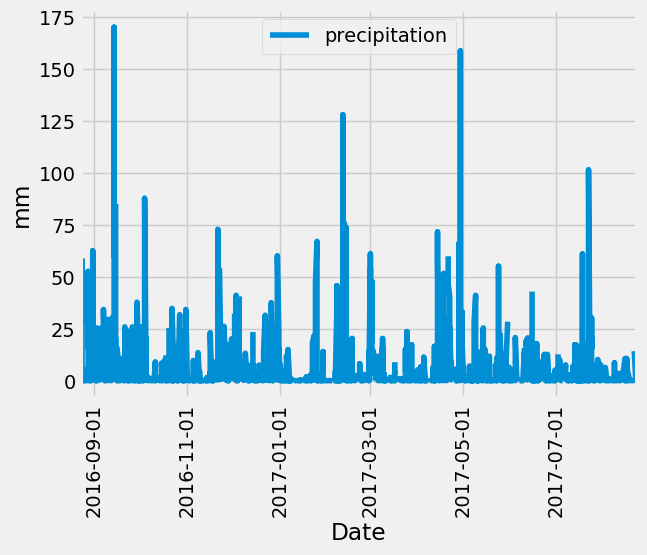

In [53]:
# Use Pandas Plotting with Matplotlib to plot the data
start_date = prcp_df['date'].min()
end_date = prcp_df['date'].max()

ax = prcp_df.plot(x="date", y="prcp")
plt.xlabel("Date")
plt.ylabel("mm")
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=90)
ax.legend(["precipitation"], loc='upper center')
plt.xlim(start_date, end_date)
plt.show()

In [57]:
# Use Pandas to calculate the summary statistics for the precipitation data
pd.DataFrame(prcp_df["prcp"].describe()).rename(columns={"prcp": "precipitation"})

,precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [58]:
# Design a query to calculate the total number of stations in the dataset
session.query(station).count()

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = (session.query(station.station, func.count(measurement.id).label('activity_count'))
    .join(measurement, station.station == measurement.station).group_by(station.station).order_by(func.count(measurement.id).desc()).all())
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [59]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'

temperature_stats = (session.query(
        func.min(measurement.tobs).label('lowest_temperature'),
        func.max(measurement.tobs).label('highest_temperature'),
        func.avg(measurement.tobs).label('average_temperature'))
        .filter(measurement.station == most_active_station_id).first())

temperature_stats

(12.2, 29.4, 22.03582251082252)

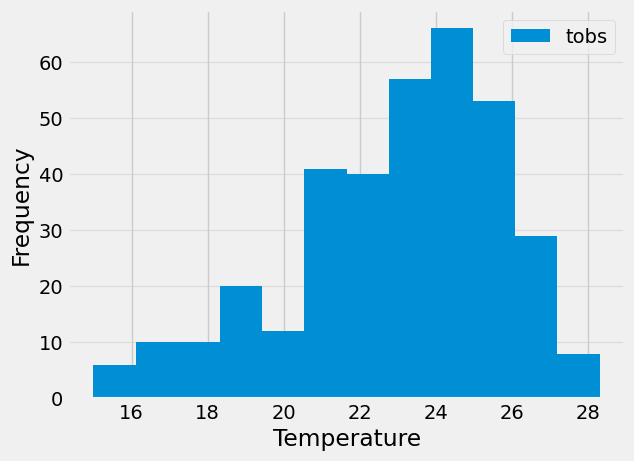

In [60]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = (session.query(measurement.date, measurement.tobs).filter(measurement.station == most_active_station_id, measurement.date >= one_year_ago).order_by(measurement.date).all())
temperature_df = pd.DataFrame(temperature_data, columns=["Date", "Temperature"])
plt.hist(temperature_df["Temperature"], bins=12, label="tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.5)
plt.legend()
plt.show()

# Close Session

In [61]:
# Close Session
session.close()
